ФИО Ковалишин Никита Игоревич

Группа ML-22

В качестве домашней работы вам необходимо будет реализовать и сравнить методы:
<b>Momentum, AdaDelta, Adam</b>.

Также вам будет предложено сравнить реализованные методы при обучении полносвязной и сверточной нейронных сетей на датасете MNIST.



# Семинар 4: "Методы оптимизации"

In [ ]:
from functools import partial
from google.colab import output
import numpy as np
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
%matplotlib inline
plt.rc('animation', html='html5')

На этом семинаре мы попробуем сравнить различные методы оптимизации.

На семинаре реализуем и сравним методы:
<b>SGD, NAG, Adagrad, RMSProp</b>.



## Реализация методов

Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

In [ ]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)

    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

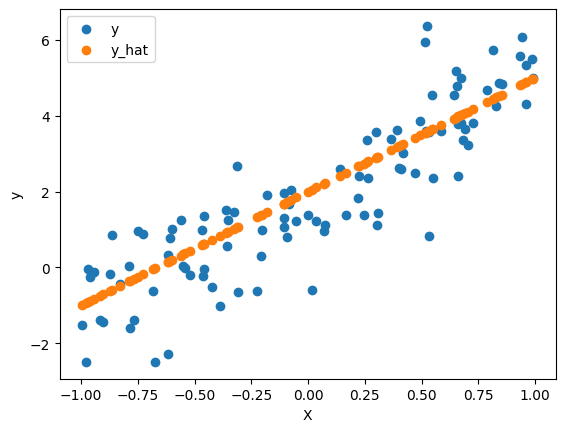

In [ ]:
size = 100

# Сгенерируем и инициализируем выборку из 100 точек
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1.)

# Построим целевые значения по сгенерированным точкам следуюим образом: y = 3 * x + 2
y_hat = 3 * X[:, 0] + 2

# Добавим шум к целевым значениям
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

# Визуализируем полученные значения:
plt.scatter(loss_animator.X[:, 0], loss_animator.y, label='y')
plt.scatter(loss_animator.X[:, 0], y_hat, label='y_hat')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

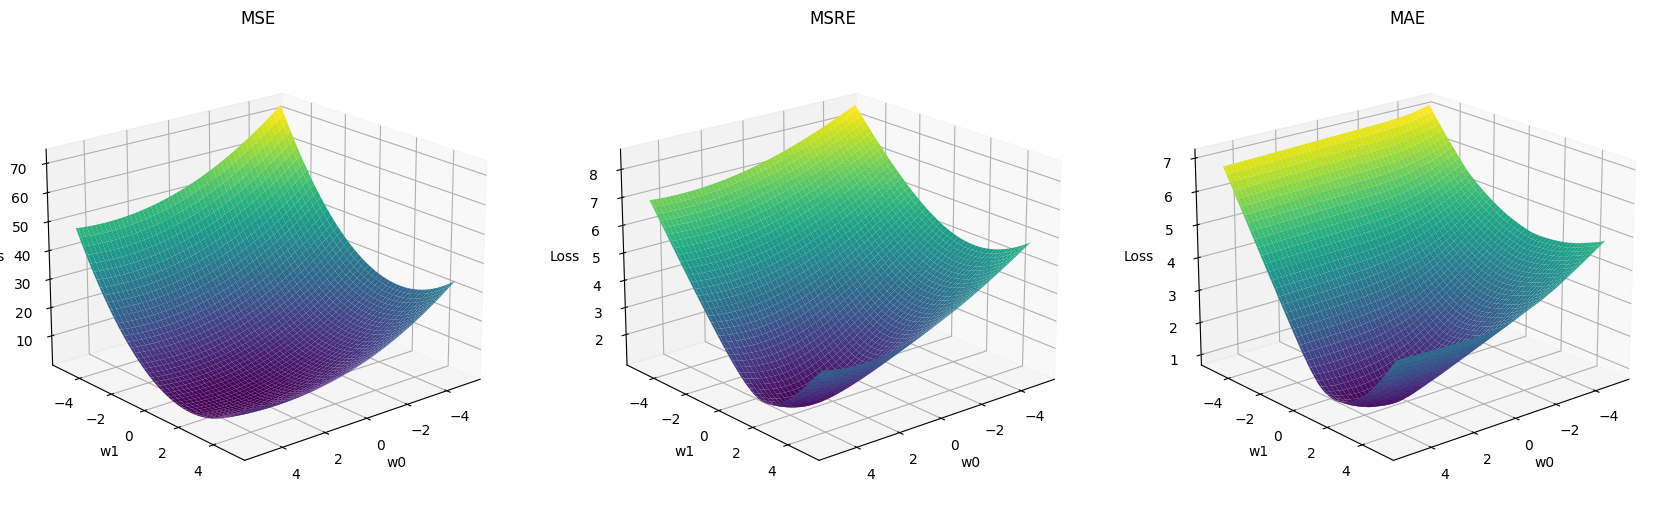

In [ ]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

1.1 Реализуем методы SGD, NAG, Adagrad, RMSProp:

In [ ]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        pass

    def step(self):
        pass

    def update_param(self, p):
        raise NotImplementedError()


In [ ]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [ ]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in optim_list:
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }

    return loss_animator.animate(num_iter, data, step_skip=step_skip)

### SGD
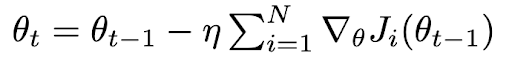

In [ ]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.lr * p.grad

    def to(self, device = 'cpu'):
        return self

### Nesterov accelerated gradient
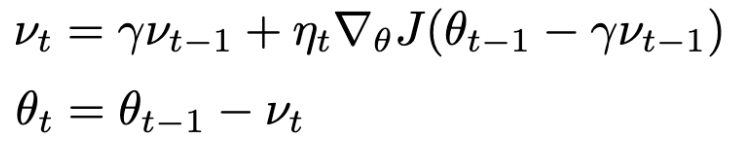

Упрощенная формула:

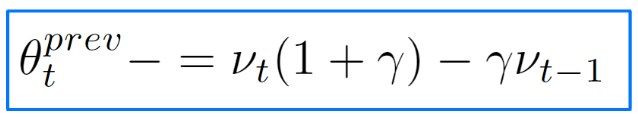

In [ ]:
class NAG(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma
        self.prev_momentum = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                prev_momentum = self.prev_momentum[i]
                self.prev_momentum[i] = self.gamma*prev_momentum + self.lr*p.grad
                p -= self.prev_momentum[i]*(1 + self.gamma) - self.gamma*prev_momentum

    def to(self, device = "cpu"):
        for i in range(len(self.prev_momentum)):
            self.prev_momentum[i] = self.prev_momentum[i].to(device)
        return self

### AdaGrad
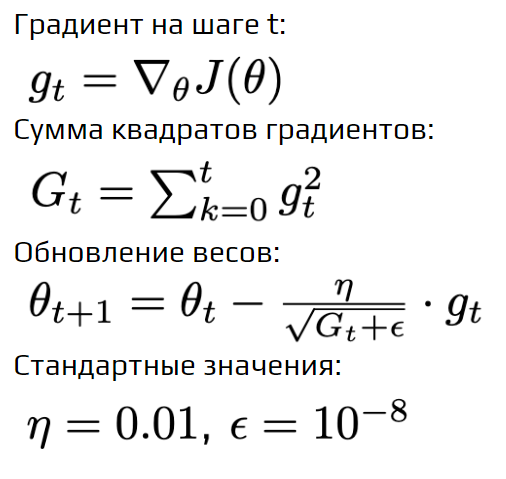

In [ ]:
class AdaGrad(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2):
        super().__init__(params)
        self.eta = eta
        self.epsilon = epsilon
        self.G = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.G[i] += 0.1 * p.grad**2
                p -= p.grad * self.eta / torch.sqrt(self.G[i] + self.epsilon)

    def to(self, device = "cpu"):
        for i in range(len(self.G)):
            self.G[i] = self.G[i].to(device)
        return self

### RMSProp

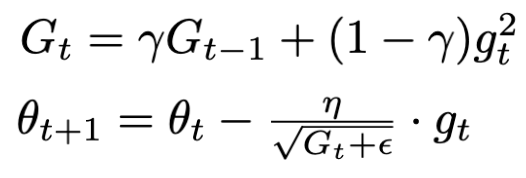

In [ ]:
class RMSProp(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2, gamma=0.9):
        super().__init__(params)
        self.epsilon = epsilon
        self.eta = eta
        self.gamma = gamma
        self.G = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.G[i] = self.gamma * self.G[i] + (1 - self.gamma)*(p.grad**2)
                p -= p.grad * self.eta / torch.sqrt(self.G[i] + self.epsilon)


    def to(self, device = "cpu"):
        for i in range(len(self.G)):
            self.G[i] = self.G[i].to(device)
        return self

In [ ]:
from functools import partial

points, losses = optimize_function(partial(loss_animator.loss_func, loss=mse), SGD, {}, start_point=[-4, -4], num_iter=50)

In [ ]:
compare_optimizers(
    loss_animator,
    mse,
    [
        ['SGD', SGD, {'lr': 1e-1}],
        ['NAG', NAG, {'lr': 1e-1}],
        ['AdaGrad', AdaGrad, {'eta' : 1}],
        ['RMSProp', RMSProp, {'eta' : 1}],
    ],
    start_point=[-4, -4],
    num_iter=50
)

### Momentum

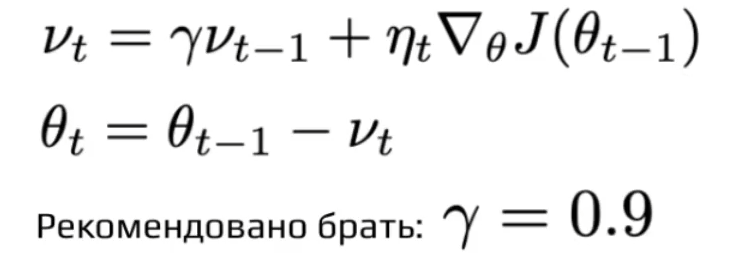

In [ ]:
class Momentum(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma
        self.prev_momentum = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.prev_momentum[i] = self.prev_momentum[i] * self.gamma + self.lr * p.grad
                p -= self.prev_momentum[i]

    def to(self, device = "cpu"):
        for i in range(len(self.prev_momentum)):
            self.prev_momentum[i] = self.prev_momentum[i].to(device)
        return self

### AdaDelta

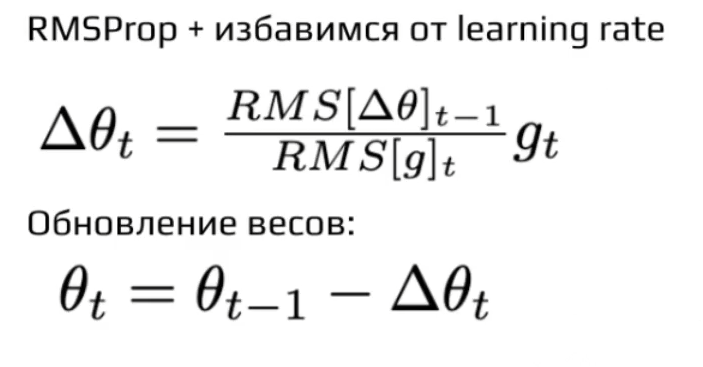

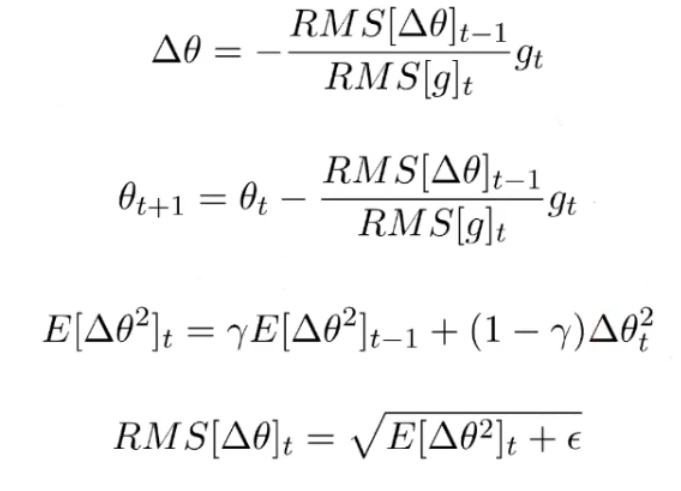

In [ ]:
class AdaDelta(Optimizer):
  #initParam отвечает за начальную инициализацию, так как от неё тоже зависит сходимость
    def __init__(self, params, epsilon=1e-6, gamma=0.9, initParam=0.1):
        super().__init__(params)
        self.epsilon = epsilon
        self.gamma = gamma
        self.G = [torch.zeros(p.shape) for p in self.params]
        self.E = [initParam * torch.rand(1).item() * torch.ones(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.G[i] = self.gamma * self.G[i] + (1 - self.gamma)*(p.grad**2) #!!!
                RMSDeltaTetaPrev = torch.sqrt(self.E[i] + self.epsilon)
                RMSGt = torch.sqrt(self.G[i] + self.epsilon)
                deltaTeta = p.grad * RMSDeltaTetaPrev / RMSGt
                p -= deltaTeta
                self.E[i] = self.gamma * self.E[i] + (1 - self.gamma)*(deltaTeta**2)

    def to(self, device = "cpu"):
        for i in range(len(self.G)):
            self.G[i] = self.G[i].to(device)
        for i in range(len(self.E)):
            self.E[i] = self.E[i].to(device)
        return self

### Adam

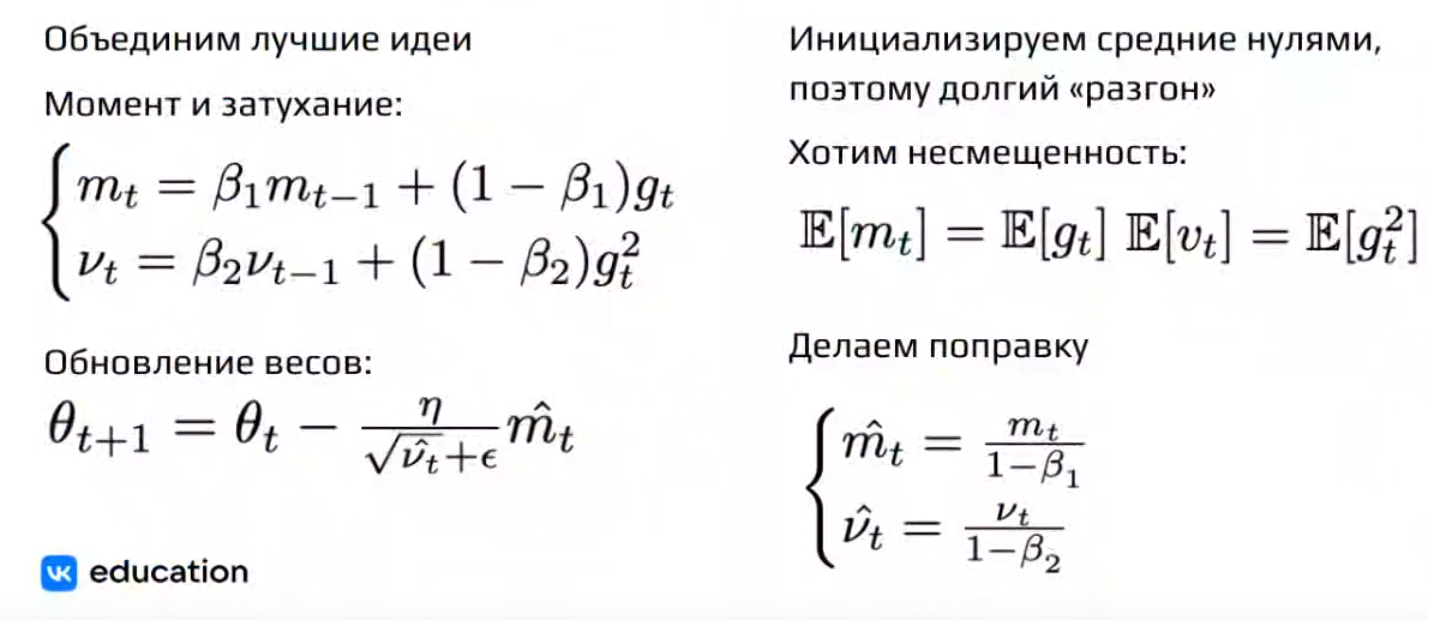

In [ ]:
class Adam(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2, beta1 = 0.6, beta2 = 0.99):
        super().__init__(params)
        self.epsilon = epsilon
        self.eta = eta
        self.beta1 = beta1
        self.beta2 = beta2
        self.momentum = [torch.zeros(p.shape) for p in self.params]
        self.nu = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.momentum[i] = self.beta1*self.momentum[i] + (1 - self.beta1)*p.grad
                self.nu[i] = self.beta2*self.nu[i] + (1 - self.beta2)*(p.grad**2)
                momentum_align = self.momentum[i] / (1 - self.beta1)
                nu_align = self.nu[i] / (1 - self.beta2)
                p-= self.eta*momentum_align / (torch.sqrt(nu_align) + self.epsilon)

    def to(self, device = "cpu"):
        for i in range(len(self.momentum)):
            self.momentum[i] = self.momentum[i].to(device)
        for i in range(len(self.nu)):
            self.nu[i] = self.nu[i].to(device)
        return self

Сравнение реализованных методов <b>Momentum, AdaDelta, Adam</b> на простом примере с 3*x + 2:

In [ ]:
compare_optimizers(
    loss_animator,
    mse,
    [
        ['Momentum', Momentum, {'lr': 1e-1}],
        ['AdaDelta (iP=0.1)', AdaDelta, {'initParam' : 0.1}],
        ['AdaDelta (iP=1)', AdaDelta, {'initParam' : 1}],
        ['AdaDelta (iP=10)', AdaDelta, {'initParam' : 10}],
        ['Adam', Adam, {'eta' : 1}],
    ],
    start_point=[-4, -4],
    num_iter=50
)

### Выводы по первичному сравнению

**Сравнительный обзор эффективности оптимизаторов Momentum, AdaDelta, Adam.**

1) Быстрее всех сошёлся Adam

2) Так же видно, как начальная инициализация RMS влияет на сходимость AdaDelta. Чем больше коэффициент разброса при инициализации, тем хуже сходимость.

3) Momentum оказался на 3 месте.

**Сравнительный анализ результатов Momentum, AdaDelta, Adam.**

Будет сравниваться победитель (**Adam**) с условно (при заданных параметрах) проигравшими оптимизаторами (**AdaDelta**, **Momentum**)

1) Если сравнивать **Adam** с **AdaDelta**, то **Adam** победил за счёт применения двух подходов.

Первый подход - **глобальная сходимость**. За счёт **глобальной сходимости** с помощью накопления **моментумов** (издалека сойтись поближе) он смог приблизиться к какой-то локальной окрестности **оптимума**. Одновременно с этим происходило накопление **затухания** для локальной сходимости;

Второй подход - **локальная сходимость**. Итак, мы подошли к локальной окрестности **оптимума**, градиенты уменьшились. Но мы накопили **затухание**. Оно позволит нам нормально сойтись в локальной окрестности точки **оптимума** к самому **оптимуму**, даже если возможны какие-то скачки при накоплении **моментума**.

!!! Замечание - не стоит сильно долго болтаться вокруг **оптимума**. Сошлись к **оптимуму**, останавливаем обучение. Дело в том, что возле оптимума **затухание** тоже начинает понемногу уменьшаться. Это значит, что рано или поздно, мы можем вылететь из локальной окрестности, если вдруг однажды наткнёмся на большой градиент. **Моментум** появится, а **затухания** нет. Как говорится, до свидания, **оптимум**) То есть может проявиться схожая проблема, как у **RMSProp**. Так же не забываем про начальный **learning_rate**. Он тоже должен быть в более менее адекватных пределах подобран.

У **AdaDelta** какие проблемы? Там сходимость осуществляется за счёт накопленного **затухания**, умноженного на накопленный сдвиг. В этом есть разница. Если смотреть с точки зрения **глобальной сходимости**, в этом нет ничего страшного, мы рано или поздно сможем достигнуть какой-то локальной окрестности оптимума, так как мы запоминаем **сдвиги**, которые в большинстве будут направлены к **оптимуму**.

Но вот с **локальной сходимостью** могут быть проблемы. В локальной окрестности **оптимума** из-за неудачной начальной инициализации может случиться то, что накопление **сдвига** будет больше, чем нужно, так как он не избавился от влияния начальной инициализации. Из-за этого отношение которое заменяет **learning_rate**, будет около 1. Попытаюсь это объяснить. Тут может случиться **согласованность** числителя и знаменателя, так как градиент, который в числителе, по сути определяет будущий **сдвиг**, который будет на следующем шаге в числителе. Мы сдвинемся на приличный шаг в окрестности оптимума, запомним это в числителе и знаменателе. Но запоминание будет лишь частичным, а вот накопление сохраняться будет долго. Тем более градиент напрямую определяет **сдвиг**. Так что вот эти накопления в числителе и знаменателе будут согласовываться за счёт своей памяти о предыдущих градиентах. Это плохо, так как в таком случае мы будем очень медленно сходиться к точке **оптимума** и будем долго болтаться туда-сюда возле её окрестности, как это показано выше.

2) Если сравнивать **Adam** и **Momentum**, то тут всё понятно. **Momentum** хорошо проявляет себя в **глобальной сходимости**, когда нужно дойти до окрестности точки **оптимума**, но может плохо справляться с поиском самой точки в **локальной сходимости**. **Аdam** эту функцию имеет.

Таким образом, **Adam** обоснованно занимает первое место.

## Обучение полносвязной нейронной сети на MNIST

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from torch import nn

transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=6)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False, num_workers=6)

In [ ]:
class MLP_MNIST(nn.Module):

  def __init__(self):
    super(MLP_MNIST, self).__init__()
    self.layers = nn.Sequential(nn.Linear(28*28, 100),
                                nn.ReLU(),
                                nn.Linear(100, 100),
                                nn.ReLU(),
                                nn.Linear(100, 10))

  def forward(self, X):
    X = X.flatten(1, -1)
    return self.layers(X)

In [ ]:
def TrainAndValidation(train_loader, val_loader, model, criterion, optimizer, device, n_iters = 20):
  model = model.to(device)
  optimizer = optimizer.to(device)
  criterion = criterion.to(device)
  trainLossLst = []
  trainAccuracyLst = []
  valLossLst = []
  valAccuracyLst = []
  for epoch in range(n_iters):
    model.train()
    trainLossLst += [0]
    trainAccuracyLst += [0]
    for features, targets in train_loader:
      optimizer.zero_grad()
      features = features.to(device)
      targets = targets.to(device)
      predictions = model(features)
      loss = criterion(predictions, targets)
      loss.backward()
      optimizer.step()
      trainLossLst[-1] += loss.item()
      trainAccuracyLst[-1] += torch.sum((predictions.argmax(dim=1) == targets).float()) / train_loader.batch_size
    trainLossLst[-1] = trainLossLst[-1] / len(train_loader) #учитывается то, что кол-во семплов во всём train'e делится нацело на размер batch'а
    trainAccuracyLst[-1] = trainAccuracyLst[-1].cpu() / len(train_loader)
    print(f"Train Loss {epoch}: {trainLossLst[-1]}")
    print(f"Train Accuracy {epoch}: {trainAccuracyLst[-1]}\n")
    #валидация
    model.eval()
    valLossLst += [0]
    valAccuracyLst += [0]
    with torch.no_grad():
      for v_features, v_targets in val_loader:
        v_features = v_features.to(device)
        v_targets = v_targets.to(device)
        v_predictions = model(v_features)
        valLossLst[-1] += criterion(v_predictions, v_targets)
        valAccuracyLst[-1] += (torch.sum((v_predictions.argmax(dim=1) == v_targets).float()) / val_loader.batch_size)
    valLossLst[-1] = valLossLst[-1].cpu() / len(val_loader)
    valAccuracyLst[-1] = valAccuracyLst[-1].cpu() / len(val_loader)
    print(f"Validation Loss {epoch}: {valLossLst[-1]}")
    print(f"Validation Accuracy {epoch}: {valAccuracyLst[-1]}\n")
  return (trainLossLst, trainAccuracyLst), (valLossLst, valAccuracyLst)

In [ ]:
MLPModelsDict = {'SGD' : MLP_MNIST(),
                 'Momentum' : MLP_MNIST(),
                 'NAG' : MLP_MNIST(),
                 'AdaGrad' : MLP_MNIST(),
                 'RMSProp' : MLP_MNIST(),
                 'AdaDelta' : MLP_MNIST(),
                 'Adam' : MLP_MNIST()
                 }

MLPOptimizers = {'SGD' : SGD(MLPModelsDict['SGD'].parameters()),
                 'Momentum' : Momentum(MLPModelsDict['Momentum'].parameters()),
                 'NAG' : NAG(MLPModelsDict['NAG'].parameters()),
                 'AdaGrad' : AdaGrad(MLPModelsDict['AdaGrad'].parameters()),
                 'RMSProp' : RMSProp(MLPModelsDict['RMSProp'].parameters(), eta = 0.001),
                 'AdaDelta' : AdaDelta(MLPModelsDict['AdaDelta'].parameters(), initParam = 0.00005),
                 'Adam' : Adam(MLPModelsDict['Adam'].parameters(), eta = 0.001)
                 }

MLPCriterionsDict = {}
MLPTrainResultsDict = {}
MLPValResultsDict = {}
for key in MLPModelsDict.keys():
    MLPCriterionsDict.update({key: nn.CrossEntropyLoss()})
    MLPTrainResultsDict.update({key: ([], [])})
    MLPValResultsDict.update({key: ([], [])})

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
print("Device connected: ", torch.cuda.get_device_name())

Device connected:  NVIDIA L4


In [ ]:
for key in MLPOptimizers.keys():
  MLPTrainResultsDict[key], MLPValResultsDict[key] = TrainAndValidation(train_loader,
                                                                        test_loader,
                                                                        MLPModelsDict[key],
                                                                        MLPCriterionsDict[key],
                                                                        MLPOptimizers[key],
                                                                        device)
  output.clear()

In [ ]:
def PlotResults(ResultsDict):
  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.title('Train Loss')
  for key in ResultsDict.keys():
    plt.plot(ResultsDict[key][0], label=key)
  plt.xlabel('Epochs', fontsize=16)
  plt.ylabel('Loss', fontsize=16)
  plt.legend(loc=0, fontsize=16)
  plt.grid()

  plt.subplot(1, 2, 2)
  plt.title('Train Accuracy')
  for key in ResultsDict.keys():
    plt.plot(ResultsDict[key][1], label=key)
  plt.xlabel('Epochs', fontsize=16)
  plt.ylabel('Loss', fontsize=16)
  plt.legend(loc=0, fontsize=16)
  plt.grid()
  plt.show()

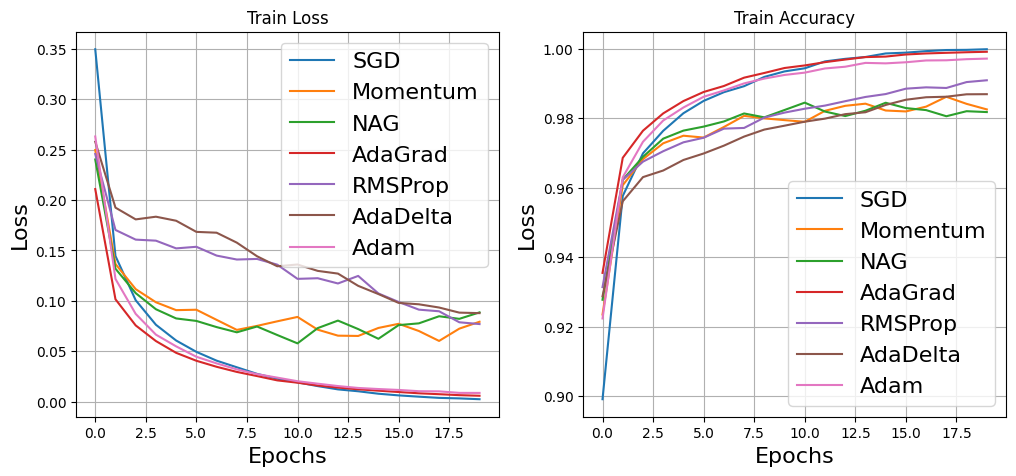

In [ ]:
PlotResults(MLPTrainResultsDict)

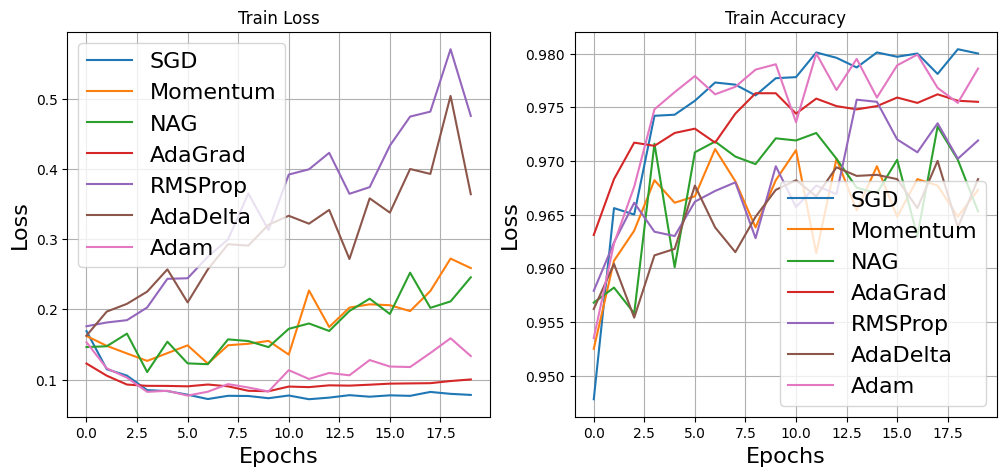

In [ ]:
PlotResults(MLPValResultsDict)

**Выводы по применению оптимизаторов для обучения полносвязной сети**

!!!Выводы делаются по валидационным графикам!!!

1) **SGD** себя хорошо показал, возможно потому что поверхность получилась без локальных минимумов, да и параметр угадан достаточно хорошо. Но тем не менее у неё нет универсальности, так что едва ли её можно считать победителем.

2) **AdaGrad** тоже себя показал хорошо, возможно потому, что изначально мы находились достаточно близко от точки глобального минимума, и затухание не успело возрасти тк сильно. Но в этом тоже универсальности мало.

3) **Adam** показал хороший результат, на уровне первых двух оптимизаторов. Единственное, о чём говорилось ранее, нужно было остановиться немного раньше, потому что стал проявляться эффект уменьшения затухания при долгом болтании вокруг точки оптимума.

4) **Momentum** и **NAG** показали не очень хороший результат, так как они не имели затухания. Опять же, если мы рядом с точкой оптимума находимся, то нам приоритетнее пользоваться затуханием, нежели моментумами.

5) **RMSProp** и **AdaDelta** показали наихудший результат как раз из-за проблем в локальной сходимости.

## Обучение свёрточной нейронной сети на MNIST

In [ ]:
class CNN_MNIST(nn.Module):

  def __init__(self):
    super(CNN_MNIST, self).__init__()
    self.conv_layers = nn.Sequential(nn.Conv2d(1, 4, kernel_size=3, padding=1),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2, stride=2),
                                nn.Conv2d(4, 12, kernel_size=3, padding=1),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2, stride=2))
    self.fc_layers = nn.Sequential(nn.Linear(7*7*12, 100),
                                nn.ReLU(),
                                nn.Linear(100, 100),
                                nn.ReLU(),
                                nn.Linear(100, 10))

  def forward(self, X):
    X = self.conv_layers(X)
    X = X.flatten(1, -1)
    return self.fc_layers(X)

In [ ]:
CNNModelsDict = {'SGD' : CNN_MNIST(), 'Momentum' : CNN_MNIST(), 'NAG' : CNN_MNIST(),
          'AdaGrad' : CNN_MNIST(), 'RMSProp' : CNN_MNIST(), 'AdaDelta' : CNN_MNIST(),
                 'Adam' : CNN_MNIST()}

CNNOptimizers =  {'SGD' : SGD(CNNModelsDict['SGD'].parameters()),
                 'Momentum' : Momentum(CNNModelsDict['Momentum'].parameters()),
                 'NAG' : NAG(CNNModelsDict['NAG'].parameters()),
                 'AdaGrad' : AdaGrad(CNNModelsDict['AdaGrad'].parameters()),
                 'RMSProp' : RMSProp(CNNModelsDict['RMSProp'].parameters(), eta = 0.001),
                 'AdaDelta' : AdaDelta(CNNModelsDict['AdaDelta'].parameters(), initParam = 0.00005),
                 'Adam' : Adam(CNNModelsDict['Adam'].parameters(), eta = 0.001)}

CNNCriterionsDict = {}
CNNTrainResultsDict = {}
CNNValResultsDict = {}
for key in CNNModelsDict.keys():
    CNNCriterionsDict.update({key: nn.CrossEntropyLoss()})
    CNNTrainResultsDict.update({key: ([], [])})
    CNNValResultsDict.update({key: ([], [])})

In [ ]:
for key in CNNOptimizers.keys():
  CNNTrainResultsDict[key], CNNValResultsDict[key] = TrainAndValidation(train_loader,
                                                                        test_loader,
                                                                        CNNModelsDict[key],
                                                                        CNNCriterionsDict[key],
                                                                        CNNOptimizers[key],
                                                                        device)
  output.clear()

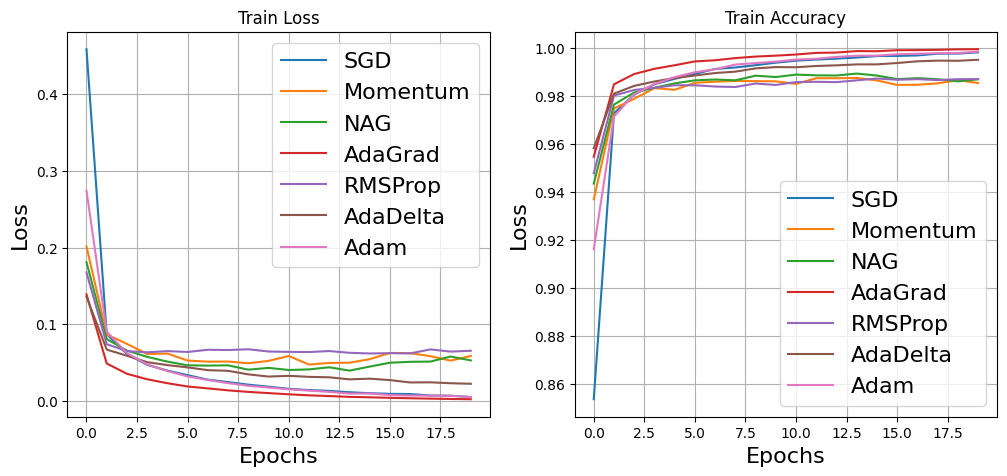

In [ ]:
PlotResults(CNNTrainResultsDict)

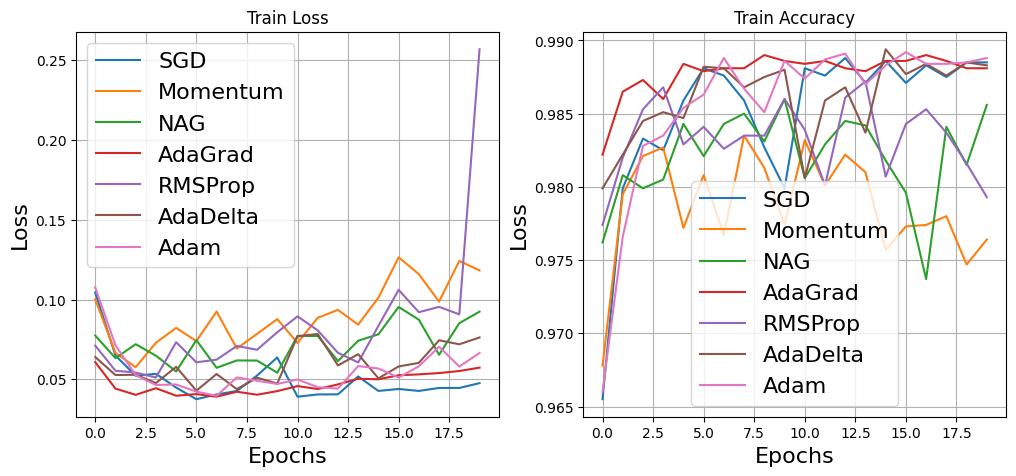

In [ ]:
PlotResults(CNNValResultsDict)

**Выводы по применению оптимизаторов для обучения свёрточной сети**

Свёрточная сеть обучилась получше полносвязной, если смотреть по валидации. Но это понятно, для распознавания картинок оCNN лучше подходят.

Здесь всё аналогично, за исключением того, что AdaDelta стала получше. Но опять же, это всё зависит от того, как мы подошли к локальному минимуму. Видимо накопление сдвига успело избавиться от влияния начальной инициализации, поэтому в окрестность оптимума мы заходим без большого остаточного сдвига.